In [30]:
import xgboost as xgb
import numpy as np
import pandas as pd
import rasterio
import glob
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def read_tif_files(directory_path, pattern):
    """
    Read all TIFF files matching the pattern from directory
    pattern: 'NDMI' or 'NDVI'
    Returns: Dictionary with filenames as keys and numpy arrays as values
    """
    # Get list of files in directory
    try:
        files = os.listdir(directory_path)
        # Filter for TIFF files matching the pattern
        tif_files = sorted([f for f in files if f.startswith(pattern) and f.endswith('.tif')])
        
        if not tif_files:
            raise ValueError(f"No {pattern} TIFF files found in {directory_path}")
            
        data_dict = {}
        for filename in tif_files:
            file_path = os.path.join(directory_path, filename)
            with rasterio.open(file_path) as src:
                data = src.read(1)
                data_dict[filename] = data
                
        print(f"Loaded {len(data_dict)} {pattern} files from {directory_path}")
        return data_dict
        
    except Exception as e:
        print(f"Error reading {pattern} files from {directory_path}: {str(e)}")
        raise

In [24]:
def prepare_features(ndmi_dir, ndvi_dir, precip_df):
    """
    Prepare features from TIFF files and precipitation data
    precip_df: DataFrame with columns [tiff_file, precipitation_sum, irrigation]
    """
    # Read TIFF files
    print("Reading TIFF files...")
    ndmi_files = read_tif_files(ndmi_dir, 'NDMI')
    ndvi_files = read_tif_files(ndvi_dir, 'NDVI')
    
    if len(ndmi_files) != len(ndvi_files):
        raise ValueError(f"Number of NDMI files ({len(ndmi_files)}) doesn't match NDVI files ({len(ndvi_files)})")
    
    features = []
    targets = []
    dates = []
    # print(ndmi_files)
    
    print("\nPreparing feature vectors...")
    # Process files in pairs, starting from the second file

    previous_tuple = list(zip(ndmi_files, ndvi_files))[0]  # this is the first pair of keys in dictionaries with NDVI and NDMI data

    for i in list(zip(ndmi_files, ndvi_files))[1:]:
        # Current files
        current_ndmi_filename = i[0]
        current_ndmi_data = ndmi_files[i[0]]
        current_ndvi_data = ndvi_files[i[1]]
        
        # Previous files
        prev_ndmi_data = ndmi_files[previous_tuple[0]]
        prev_ndvi_data = ndvi_files[previous_tuple[1]]
        
        # Find matching precipitation data
        precip_row = precip_df[precip_df['tiff_file'] == current_ndmi_filename]
        
        if len(precip_row) == 0:
            print(f"Warning: No precipitation data found for {current_ndmi_filename}")
            continue
        
        # Get precipitation and irrigation values
        precip = precip_row.iloc[0]['weekly_precipitation_mm']
        irrigation = precip_row.iloc[0]['average_amount_mm']
        
        # Prepare feature vector
        feature_row = np.concatenate([
            current_ndmi_data.flatten(),  # Current NDMI
            current_ndvi_data.flatten(),  # Current NDVI
            prev_ndmi_data.flatten(),     # Previous NDMI
            prev_ndvi_data.flatten(),     # Previous NDVI
            [precip]                      # Precipitation
        ])
        
        features.append(feature_row)
        targets.append(irrigation)  # irrigation levels are our target values
        dates.append(current_ndmi_filename)

        previous_tuple = i  # assign the current tuple to be the previous tuple for the next iteration
    
    features = np.array(features)
    targets = np.array(targets)
    
    print(f"\nDataset summary:")
    print(f"Total samples: {len(features)}")
    print(f"Feature vector size: {features[0].shape[0]} elements")
    print(f"Date range: {dates[0]} to {dates[-1]}")
    
    # Additional verification
    print(f"NDMI values range: {features[:, :351].min():.3f} to {features[:, :351].max():.3f}")
    print(f"NDVI values range: {features[:, 351:702].min():.3f} to {features[:, 351:702].max():.3f}")
    print(f"Precipitation range: {features[:, -1].min():.1f} to {features[:, -1].max():.1f}")
    print(f"Irrigation range: {targets.min():.1f} to {targets.max():.1f}")
    
    return features, targets, dates
   

In [25]:
def prepare_features_2(ndmi_dir, ndvi_dir, precip_df):
    """
    Prepare features from TIFF files and precipitation data
    precip_df: DataFrame with columns [tiff_file, precipitation_sum, irrigation]
    """
    # Read TIFF files
    print("Reading TIFF files...")
    ndmi_files = read_tif_files(ndmi_dir, 'NDMI')
    ndvi_files = read_tif_files(ndvi_dir, 'NDVI')
    
    if len(ndmi_files) != len(ndvi_files):
        raise ValueError(f"Number of NDMI files ({len(ndmi_files)}) doesn't match NDVI files ({len(ndvi_files)})")
    
    features = []
    targets = []
    dates = []
    # print(ndmi_files)
    
    print("\nPreparing feature vectors...")
    # Process files in pairs, starting from the second file

    for i in list(zip(ndmi_files, ndvi_files)):
        # Current files
        current_ndmi_filename = i[0]
        current_ndmi_data = ndmi_files[i[0]]
        current_ndvi_data = ndvi_files[i[1]]
        
        # Find matching precipitation data
        precip_row = precip_df[precip_df['tiff_file'] == current_ndmi_filename]
        
        if len(precip_row) == 0:
            print(f"Warning: No precipitation data found for {current_ndmi_filename}")
            continue
        
        # Get precipitation and irrigation values
        precip = precip_row.iloc[0]['weekly_precipitation_mm']
        irrigation = precip_row.iloc[0]['average_amount_mm']
        
        # Prepare feature vector
        feature_row = np.concatenate([
            current_ndmi_data.flatten(),  # Current NDMI
            current_ndvi_data.flatten(),  # Current NDVI
            [precip]                      # Precipitation
        ])
        
        features.append(feature_row)
        targets.append(irrigation)  # irrigation levels are our target values
        dates.append(current_ndmi_filename)


    features = np.array(features)
    targets = np.array(targets)
    
    print(f"\nDataset summary:")
    print(f"Total samples: {len(features)}")
    print(f"Feature vector size: {features[0].shape[0]} elements")
    print(f"Date range: {dates[0]} to {dates[-1]}")
    
    # Additional verification
    print(f"NDMI values range: {features[:, :351].min():.3f} to {features[:, :351].max():.3f}")
    print(f"NDVI values range: {features[:, 351:702].min():.3f} to {features[:, 351:702].max():.3f}")
    print(f"Precipitation range: {features[:, -1].min():.1f} to {features[:, -1].max():.1f}")
    print(f"Irrigation range: {targets.min():.1f} to {targets.max():.1f}")
    
    return features, targets, dates
   

In [4]:

def train_irrigation_model_2(features, targets):
    # Time series split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 6,
        'n_estimators': 100,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0
    }
    
    models = []
    scores = []
    
    for train_idx, val_idx in tscv.split(features):
        X_train, X_val = features[train_idx], features[val_idx]
        y_train, y_val = targets[train_idx], targets[val_idx]
        
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False
        )
        
        pred = model.predict(X_val)
        score = r2_score(y_val, pred)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        
        models.append(model)
        scores.append({'R2': score, 'RMSE': rmse})
    
    best_model_idx = np.argmax([s['R2'] for s in scores])
    return models[best_model_idx], scores

In [5]:
def optimize_irrigation(model, features, current_irrigation):
    optimal_irrigation = model.predict(features.reshape(1, -1))[0]
    
    # Apply constraints
    min_irrigation = 0
    max_irrigation = 50  # Adjust based on your requirements
    
    optimal_irrigation = np.clip(optimal_irrigation, min_irrigation, max_irrigation)
    savings = current_irrigation - optimal_irrigation if optimal_irrigation < current_irrigation else 0
    
    return optimal_irrigation, savings

In [20]:
ndmi_dir = "data/NDMI_Weekly_Exports/NDMI_Weekly_Exports_2019_2024"
ndvi_dir = "data/NDVI_Weekly_Exports/NDVI_Weekly_Exports_2019_2024"
# Load precipitation and irrigation data
precip_df = pd.read_csv('data/irrigation_estimates.csv')  # Should contain average_amount_mm (irrigation), weekly_precipitation_mm, tiff_file

In [21]:
# Prepare features
print("Preparing features...")
# features, targets, dates = prepare_features(ndmi_dir, ndvi_dir, precip_df)
features, targets, dates = prepare_features(ndmi_dir, ndvi_dir, precip_df)

Preparing features...
Reading TIFF files...
Loaded 149 NDMI files from data/NDMI_Weekly_Exports/NDMI_Weekly_Exports_2019_2024
Loaded 149 NDVI files from data/NDVI_Weekly_Exports/NDVI_Weekly_Exports_2019_2024

Preparing feature vectors...

Dataset summary:
Date range: NDMI_2019-03-12_to_2019-03-19.tif to NDMI_2024-11-04_to_2024-11-11.tif


In [26]:
features2, targets2, dates2 = prepare_features_2(ndmi_dir, ndvi_dir, precip_df)

Reading TIFF files...
Loaded 149 NDMI files from data/NDMI_Weekly_Exports/NDMI_Weekly_Exports_2019_2024
Loaded 149 NDVI files from data/NDVI_Weekly_Exports/NDVI_Weekly_Exports_2019_2024

Preparing feature vectors...

Dataset summary:
Total samples: 146
Feature vector size: 703 elements
Date range: NDMI_2019-03-12_to_2019-03-19.tif to NDMI_2024-11-04_to_2024-11-11.tif
NDMI values range: nan to nan
NDVI values range: nan to nan
Precipitation range: 0.0 to 17.8
Irrigation range: 0.0 to 30.6


In [39]:
def train_irrigation_model_1(features, targets, dates):
    """
    Train XGBoost model with time series cross-validation
    """
    # Convert to numpy arrays if they aren't already
    features = np.array(features, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    # Time series split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    

    # XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 6,
        'n_estimators': 100,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'missing': np.nan  # Explicit nan handling
    }
    
    # Store results
    fold_scores = []
    predictions = np.zeros_like(targets)
    feature_importances = None
    
    print("\nTraining model with time series cross-validation...")
    print(f"Features shape: {features.shape}")
    print(f"Targets shape: {targets.shape}")
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(features), 1):
        # Convert indices to numpy arrays if needed
        train_idx = np.array(train_idx)
        val_idx = np.array(val_idx)
        
        X_train, X_val = features[train_idx], features[val_idx]
        y_train, y_val = targets[train_idx], targets[val_idx]
        
        print(f"\nFold {fold}:")
        print(f"Training set shape: {X_train.shape}")
        print(f"Validation set shape: {X_val.shape}")
        
        # Train model
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train, 
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # Make predictions
        val_pred = model.predict(X_val)
        predictions[val_idx] = val_pred
        
        # Calculate metrics
        r2 = r2_score(y_val, val_pred)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        mae = mean_absolute_error(y_val, val_pred)
        
        fold_scores.append({
            'fold': fold,
            'R2': r2,
            'RMSE': rmse,
            'MAE': mae,
            'val_dates': [dates[i] for i in val_idx]
        })
        
        # Store feature importance (from last fold)
        feature_importances = model.feature_importances_
        
        print(f"R2 Score: {r2:.3f}")
        print(f"RMSE: {rmse:.3f} mm")
        print(f"MAE: {mae:.3f} mm")
        print(f"Validation period: {dates[val_idx[0]]} to {dates[val_idx[-1]]}")
    
    # Calculate average metrics
    avg_r2 = np.mean([score['R2'] for score in fold_scores])
    avg_rmse = np.mean([score['RMSE'] for score in fold_scores])
    avg_mae = np.mean([score['MAE'] for score in fold_scores])
    
    print("\nAverage metrics across all folds:")
    print(f"R2 Score: {avg_r2:.3f}")
    print(f"RMSE: {avg_rmse:.3f} mm")
    print(f"MAE: {avg_mae:.3f} mm")
    
    # Analyze feature importance
    feature_names = (
        [f'ndmi_current_{i}' for i in range(351)] +
        [f'ndvi_current_{i}' for i in range(351)] +
        [f'ndmi_prev_{i}' for i in range(351)] +
        [f'ndvi_prev_{i}' for i in range(351)] +
        ['precipitation']
    )
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'date': dates,
        'actual_irrigation': targets,
        'predicted_irrigation': predictions
    })
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(dates)), results_df['actual_irrigation'], 'b-', label='Actual Irrigation')
    plt.plot(range(len(dates)), results_df['predicted_irrigation'], 'r--', label='Predicted Irrigation')
    plt.title('Actual vs Predicted Irrigation Levels')
    plt.xlabel('Time Steps')
    plt.ylabel('Irrigation (mm)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model, results_df, importance_df


Training model with time series cross-validation...
Features shape: (146, 1405)
Targets shape: (146,)

Fold 1:
Training set shape: (26, 1405)
Validation set shape: (24, 1405)
R2 Score: -0.323
RMSE: 6.791 mm
MAE: 4.853 mm
Validation period: NDMI_2020-03-18_to_2020-03-25.tif to NDMI_2020-11-02_to_2020-11-09.tif

Fold 2:
Training set shape: (50, 1405)
Validation set shape: (24, 1405)
R2 Score: 0.328
RMSE: 5.720 mm
MAE: 4.909 mm
Validation period: NDMI_2021-02-19_to_2021-02-26.tif to NDMI_2021-10-28_to_2021-11-04.tif

Fold 3:
Training set shape: (74, 1405)
Validation set shape: (24, 1405)
R2 Score: -0.018
RMSE: 5.502 mm
MAE: 3.935 mm
Validation period: NDMI_2022-02-12_to_2022-02-19.tif to NDMI_2022-10-07_to_2022-10-14.tif

Fold 4:
Training set shape: (98, 1405)
Validation set shape: (24, 1405)
R2 Score: 0.414
RMSE: 5.881 mm
MAE: 4.089 mm
Validation period: NDMI_2022-10-14_to_2022-10-21.tif to NDMI_2023-10-07_to_2023-10-14.tif

Fold 5:
Training set shape: (122, 1405)
Validation set shape: 

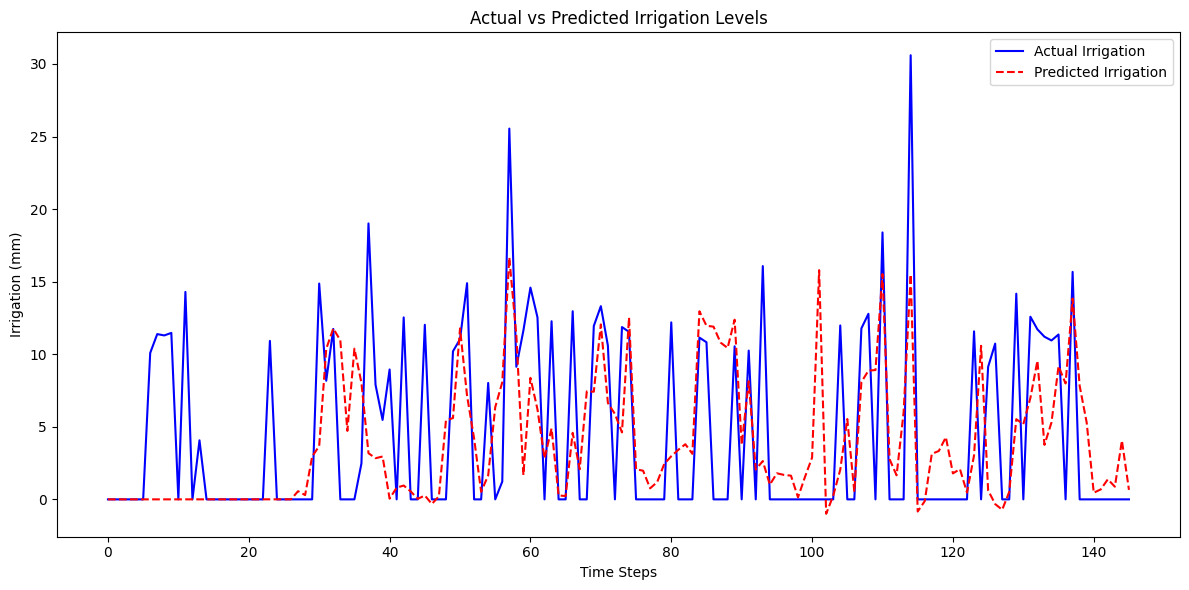

In [40]:
model, results_df, importance_df = train_irrigation_model_1(features, targets, dates)